In [1]:
# import packages
import pandas as pd
import os
import numpy as np
import seaborn as sns
import missingno as msno
import sklearn 
from plotnine import ggplot, aes, geom_line
import math

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from skranger.ensemble import RangerForestRegressor
from sklearn.metrics import mean_squared_error

import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

In [2]:
# Path to the folder containing the chunked data
folder_path = "../Output_datasets/GeoDS_mobility_flow_prediction/Chunked_merged_data"

In [3]:
# List of dataframes to store the data from each file
chunks = []
# Loop through each file in the folder
for filename in os.listdir(folder_path):
    # Check if the file is a CSV file
    if filename.endswith(".csv"):
        # Load the file into a dataframe
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath)
        # Append the dataframe to the list
        chunks.append(df)

In [4]:
# Sanity check: concatenate all chunks, keep unique and look at number of observations
raw_data = pd.concat(chunks).drop_duplicates()

# conditionally select rows based on a condition
len(raw_data)

338400

<AxesSubplot:>

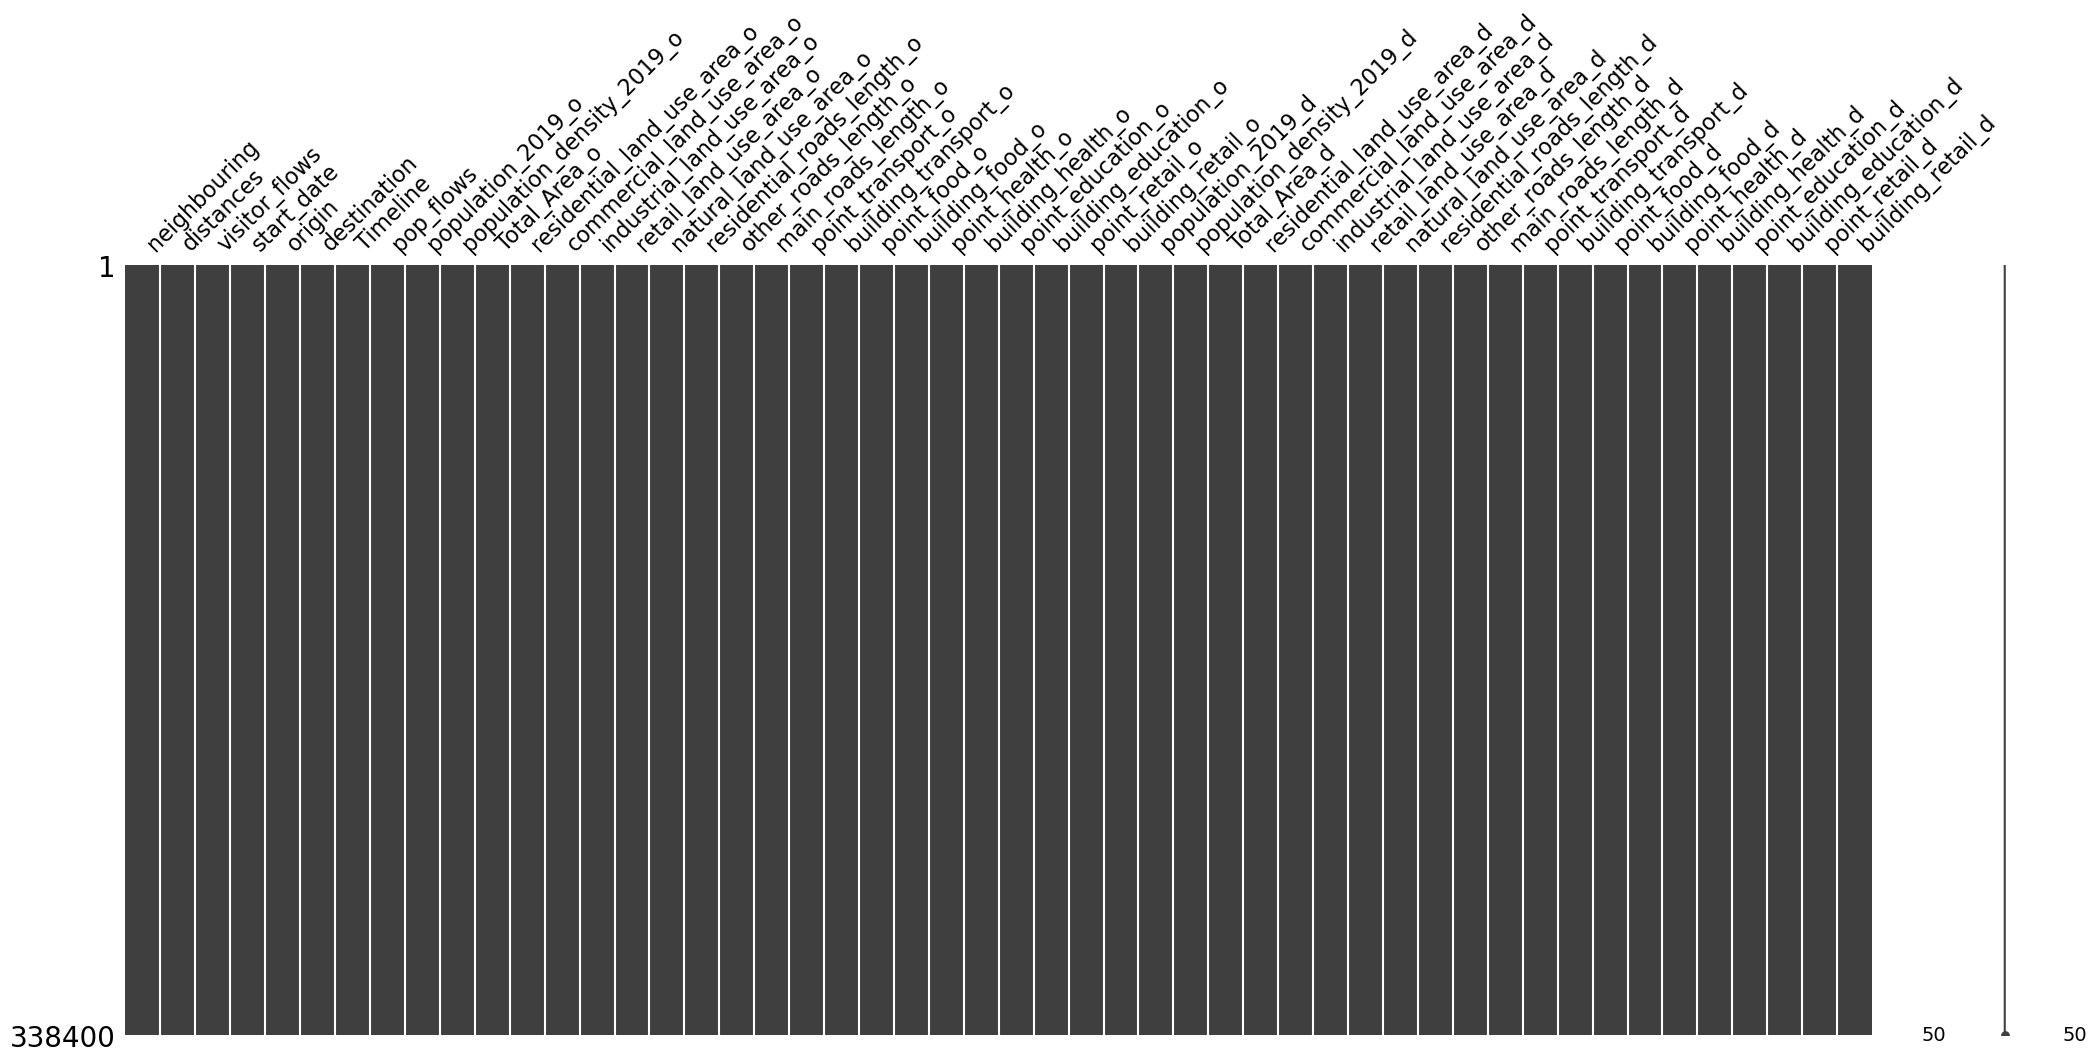

In [5]:
msno.matrix(raw_data)

In [6]:
to_filter = raw_data.isna().sum()
to_filter[to_filter > 0]

Series([], dtype: int64)

In [7]:
print(raw_data.dtypes)

neighbouring                   float64
distances                      float64
visitor_flows                    int64
start_date                      object
origin                          object
destination                     object
Timeline                         int64
pop_flows                        int64
population_2019_o                int64
population_density_2019_o      float64
Total_Area_o                    object
residential_land_use_area_o    float64
commercial_land_use_area_o     float64
industrial_land_use_area_o     float64
retail_land_use_area_o         float64
natural_land_use_area_o        float64
residential_roads_length_o     float64
other_roads_length_o           float64
main_roads_length_o            float64
point_transport_o                int64
building_transport_o             int64
point_food_o                     int64
building_food_o                  int64
point_health_o                   int64
building_health_o                int64
point_education_o        

In [8]:
h2o.init(nthreads=-1, max_mem_size = "32g")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_371"; Java(TM) SE Runtime Environment (build 1.8.0_371-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.371-b11, mixed mode)
  Starting server from /Users/ramzi.chariag/opt/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/07/r8yrsw3j65v2937ssq1kyq8r0000gn/T/tmp7ny8gf6t
  JVM stdout: /var/folders/07/r8yrsw3j65v2937ssq1kyq8r0000gn/T/tmp7ny8gf6t/h2o_ramzi_chariag_started_from_python.out
  JVM stderr: /var/folders/07/r8yrsw3j65v2937ssq1kyq8r0000gn/T/tmp7ny8gf6t/h2o_ramzi_chariag_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Vienna
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,"21 days, 6 hours and 59 minutes"
H2O_cluster_name:,H2O_from_python_ramzi_chariag_potklj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,28.43 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


In [9]:
drf = H2ORandomForestEstimator(ntrees = 50, min_rows=10, nfolds = 5, stopping_metric= 'rmse', seed = 42)

# define the hyperparameter grid
tune_grid = {
    'max_depth': [15, 18, 20],
    'mtries': [21, 23]
    }

drf_grid = H2OGridSearch(model=drf,
                          hyper_params=tune_grid,
                          parallelism = 0
                          )

In [10]:
data_out = pd.DataFrame()

for chunk in chunks:
    data = chunk.copy()

    # define the list of features to be used 
    features = list(data.columns)
    features = features.remove ('pop_flows')


    # remove the separators from area and convert to numeric
    data['Total_Area_o'] = data['Total_Area_o'].str.replace(r',', r'', regex=True)
    data['Total_Area_o'] = pd.to_numeric(data['Total_Area_o'])
    data['Total_Area_d'] = data['Total_Area_d'].str.replace(r',', r'', regex=True)
    data['Total_Area_d'] = pd.to_numeric(data['Total_Area_d'])


    # use categorical variables for origin and destination
    data['origin'] = data['origin'].astype('category')
    data['destination'] = data['destination'].astype('category')

    # Drop date
    data = data.drop('start_date', axis=1)

    # Shift traget
    data['pop_flows'] = data.groupby(['origin', 'destination'])['pop_flows'].shift(-1)

    # keep the last year 
    X_predic = data[data['Timeline'] == max(data['Timeline'])].drop(['pop_flows'], axis=1)

    # Drop because of shift
    data.dropna(inplace=True)

    # Convert to h2o dataframe
    data = h2o.H2OFrame(data)
    X_predic_h2o = h2o.H2OFrame(X_predic)

    # Dataset split
    data_split = data.split_frame(ratios=[0.8], seed = 42)
    data_train = data_split[0]
    data_test = data_split[1]

    # Train using 5 fold CV plus grid search and predict using best model 
    drf_grid.train(x = features, y = 'pop_flows', training_frame = data_train, validation_frame = data_test)
    drf_sorted_grid = drf_grid.get_grid(sort_by = 'rmse', decreasing = False)
    best_model = drf_sorted_grid[0]
    y_predic_h2o = best_model.predict(X_predic_h2o)
    y_predic = y_predic_h2o.as_data_frame() 

    X_predic['prediction'] = y_predic['predict'].to_numpy()

    data_out = pd.concat([data_out, X_predic])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |████████████████████████

In [11]:
# Save results
results = pd.DataFrame({
    'Timeline': data_out['Timeline']+1,
    'origin': data_out['origin'],
    'destination': data_out['destination'],
    'prediction': data_out['prediction']
})

results.to_csv('GeoDS_prediction.csv')

In [12]:
h2o.cluster().shutdown()

H2O session _sid_aba1 closed.
